In [ ]:
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, ArrayType, LongType, StructType, StructField, TimestampType

import re
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Tokenizer, CountVectorizer
from pyspark.ml.classification import NaiveBayes, DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/spark-889f4fe4-99ea-4b83-9c6a-e4/nltk_data...


Out[1]: True

In [ ]:
# Create a spark session 

spark = SparkSession.builder.appName("myApp")\
      .config("spark.driver.memory", "4g") \
      .config("spark.executor.memory", "4g") \
      .config("spark.sql.legacy.timeParserPolicy", "LEGACY")\
      .getOrCreate()

## Loading and Understanding the Data

In [ ]:
# Define a schema for the DataFrame
schema = StructType([
    StructField("Tweet ID", StringType(), True),
    StructField("Time Posted", StringType(), True),
    StructField("Tweet Content", StringType(), True),
    StructField("Publication", StringType(), True)
])

# Load the text files into a DataFrame using Spark
files = ['bbchealth', 'cbchealth', 'cnnhealth', 'everydayhealth', \
        'foxnewshealth', 'gdnhealthcare', 'goodhealth', 'KaiserHealthNews', \
        'latimeshealth', 'msnhealthnews', 'NBChealth', 'nprhealth', \
        'nytimeshealth', 'reuters_health', 'usnewshealth', 'wsjhealth']

dfs = []

for file in files:
    path = '/mnt/team8/' + file + '.txt'
    new_file = spark.read.option("delimiter", "|").csv(path, schema=schema, header=False)
    new_file = new_file.withColumn("Publication", F.lit(file))
    dfs.append(new_file)

df = dfs[0]
for i in range(1, len(dfs)):
    df = df.union(dfs[i])

In [ ]:
df.cache()

df.show(10)

+------------------+--------------------+--------------------+-----------+
|          Tweet ID|         Time Posted|       Tweet Content|Publication|
+------------------+--------------------+--------------------+-----------+
|585978391360221184|Thu Apr 09 01:31:...|Breast cancer ris...|  bbchealth|
|585947808772960257|Wed Apr 08 23:30:...|GP workload harmi...|  bbchealth|
|585947807816650752|Wed Apr 08 23:30:...|Short people's 'h...|  bbchealth|
|585866060991078401|Wed Apr 08 18:05:...|New approach agai...|  bbchealth|
|585794106170839041|Wed Apr 08 13:19:...|Coalition 'underm...|  bbchealth|
|585733482413891584|Wed Apr 08 09:18:...|Review of case ag...|  bbchealth|
|585733481608646657|Wed Apr 08 09:18:...|VIDEO: 'All day i...|  bbchealth|
|585701601131765761|Wed Apr 08 07:11:...|VIDEO: 'Overhaul ...|  bbchealth|
|585620828110397440|Wed Apr 08 01:51:...|Care for dying 'n...|  bbchealth|
|585437294120677376|Tue Apr 07 13:41:...|VIDEO: NHS: Labou...|  bbchealth|
+------------------+-----

In [ ]:
df.cache()

df.printSchema()

root
 |-- Tweet ID: string (nullable = true)
 |-- Time Posted: string (nullable = true)
 |-- Tweet Content: string (nullable = true)
 |-- Publication: string (nullable = false)



## Preprocessing the Data

In [ ]:
# Define the date format string
date_format = "EEE MMM dd HH:mm:ss Z yyyy"

# Convert the 'Time Posted' feature into a timestamp
df = df.withColumn("created_at_timestamp", F.to_utc_timestamp(F.unix_timestamp("Time Posted", date_format).cast("timestamp"), "UTC"))

# Create separate features for year and month
df = df.withColumn("Year", F.year("created_at_timestamp")) \
       .withColumn("Month", F.month("created_at_timestamp"))

In [ ]:
#Remove unnecessary features
df = df.drop("Tweet ID", "Time Posted", "timestamp", "created_at_timestamp")
df.show(10)

+--------------------+-----------+----+-----+
|       Tweet Content|Publication|Year|Month|
+--------------------+-----------+----+-----+
|Breast cancer ris...|  bbchealth|2015|    4|
|GP workload harmi...|  bbchealth|2015|    4|
|Short people's 'h...|  bbchealth|2015|    4|
|New approach agai...|  bbchealth|2015|    4|
|Coalition 'underm...|  bbchealth|2015|    4|
|Review of case ag...|  bbchealth|2015|    4|
|VIDEO: 'All day i...|  bbchealth|2015|    4|
|VIDEO: 'Overhaul ...|  bbchealth|2015|    4|
|Care for dying 'n...|  bbchealth|2015|    4|
|VIDEO: NHS: Labou...|  bbchealth|2015|    4|
+--------------------+-----------+----+-----+
only showing top 10 rows



In [ ]:
# Define tokenizer
tokenizer = nltk.tokenize.TweetTokenizer()

# Define a method to tokenize values in the tweet content feature
def tokenize_text(text):
    if isinstance(text, str):
        return tokenizer.tokenize(text)
    else:
        return []

# Define a UDF for tokenizer 
tokenize_udf = F.udf(tokenize_text, ArrayType(StringType()))

# Apply the UDF to the 'Tweet Content' feature and create a new feature 'tokenized_words'
df = df.withColumn("tokenized_words", tokenize_udf("Tweet Content"))


# Show first 10 rows
df.select("tokenized_words").show(10, truncate=False)

+----------------------------------------------------------------------------------------------+
|tokenized_words                                                                               |
+----------------------------------------------------------------------------------------------+
|[Breast, cancer, risk, test, devised, http://bbc.in/1CimpJF]                                  |
|[GP, workload, harming, care, -, BMA, poll, http://bbc.in/1ChTBRv]                            |
|[Short, people's, ', heart, risk, greater, ', http://bbc.in/1ChTANp]                          |
|[New, approach, against, HIV, ', promising, ', http://bbc.in/1E6jAjt]                         |
|[Coalition, ', undermined, NHS, ', -, doctors, http://bbc.in/1CnLwK7]                         |
|[Review, of, case, against, NHS, manager, http://bbc.in/1Ffj6ci]                              |
|[VIDEO, :, ', All, day, is, empty, ,, what, am, I, going, to, do, ?, ', http://bbc.in/1N7wSSz]|
|[VIDEO, :, ', Overhaul, neede

In [ ]:
# Define the stemmer to use in preprocessing
stemmer = SnowballStemmer(language='english')

# Define a stemmer function for stemming the tokenized words
def stem_words(tokens):
  return [stemmer.stem(token) for token in tokens]

# Define a UDF for stemming
stem_words_udf = F.udf(stem_words, ArrayType(StringType()))

# Apply the UDF on tokenized_words feature
df = df.withColumn("stemmed_words", stem_words_udf(F.col("tokenized_words")))

# Display the first 5 rows of the preprocessed data
df.show(5, truncate=False)

+----------------------------------------------------------+-----------+----+-----+---------------------------------------------------------------------+------------------------------------------------------------------+
|Tweet Content                                             |Publication|Year|Month|tokenized_words                                                      |stemmed_words                                                     |
+----------------------------------------------------------+-----------+----+-----+---------------------------------------------------------------------+------------------------------------------------------------------+
|Breast cancer risk test devised http://bbc.in/1CimpJF     |bbchealth  |2015|4    |[Breast, cancer, risk, test, devised, http://bbc.in/1CimpJF]         |[breast, cancer, risk, test, devis, http://bbc.in/1cimpjf]        |
|GP workload harming care - BMA poll http://bbc.in/1ChTBRv |bbchealth  |2015|4    |[GP, workload, harming, care, -, 

In [ ]:
# Define a lemmatizer method for performing lemmitization
def lemmatize(word_list):
    lemmatized_list = []
    for word in word_list:
        if word.endswith('s'):
            if word.endswith('ss'):
                lemmatized_word = word
            elif word.endswith('ies'):
                lemmatized_word = word[:-3] + 'y'
            else:
                lemmatized_word = word[:-1]
        elif word.endswith('ing'):
            if len(word) > 5:
                if word[-4] == word[-5]:
                    lemmatized_word = word[:-4]
                else:
                    lemmatized_word = word[:-3] + 'e'
            else:
                lemmatized_word = word[:-3]
        elif word.endswith('ed'):
            if len(word) > 4:
                if word[-3] == word[-4]:
                    lemmatized_word = word[:-3]
                else:
                    lemmatized_word = word[:-2] + 'e'
            else:
                lemmatized_word = word[:-2]
        else:
            lemmatized_word = word
        lemmatized_list.append(lemmatized_word)
    return lemmatized_list

# Define a UDF for lemmatizing words
lemmatize_udf = F.udf(lemmatize, ArrayType(StringType()))

# Apply the UDF to stemmed_words feature
df = df.withColumn('lemmatized_words', lemmatize_udf(df['stemmed_words']))

In [ ]:
# Define a regex to remove punctuation
pattern = re.compile('[^\w\s]')

# Apply the regex pattern and convert all words to lowercase
def no_punc_lower_words(words):
  return [pattern.sub('', word.lower()) for word in words]

# Define a udf to remove punctuation and lowercase the words
no_punc_lower_udf = F.udf(no_punc_lower_words, StringType())

# Apply the UDF to lemmatized_words feature
df = df.withColumn('no_punc_lower_words', no_punc_lower_udf(df['lemmatized_words']))

In [ ]:
# Tokenize the 'no_punc_lower_words' feature into a feature of lists of words
tokenizer = Tokenizer(inputCol="no_punc_lower_words", outputCol="words")
df = tokenizer.transform(df)

# Convert the list of words into a bag-of-words representation using CountVectorizer
cv = CountVectorizer(inputCol="words", outputCol="bag_of_words")
model = cv.fit(df)
df = model.transform(df)

In [ ]:
# Create an instance of the vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# define a function to obtain sentiment label for each entity in the feature
def analyze_sentiment(words):
    scores = analyzer.polarity_scores(' '.join(words))
    if scores['compound'] >= 0:
        return 'Positive'
    else:
        return 'Negative'

# define the udf for the sentiment and apply it to the no_punc_lower_words feature for the final sentiment labels
analyze_sentiment_udf = F.udf(analyze_sentiment, StringType())

df = df.withColumn("Sentiment", analyze_sentiment_udf(F.col("no_punc_lower_words")))
df.show(10)

+--------------------+-----------+----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|       Tweet Content|Publication|Year|Month|     tokenized_words|       stemmed_words|    lemmatized_words| no_punc_lower_words|               words|        bag_of_words|Sentiment|
+--------------------+-----------+----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|Breast cancer ris...|  bbchealth|2015|    4|[Breast, cancer, ...|[breast, cancer, ...|[breast, cancer, ...|[breast, cancer, ...|[[breast,, cancer...|(86721,[31,41,87,...| Positive|
|GP workload harmi...|  bbchealth|2015|    4|[GP, workload, ha...|[gp, workload, ha...|[gp, workload, ha...|[gp, workload, ha...|[[gp,, workload,,...|(86721,[0,46,641,...| Positive|
|Short people's 'h...|  bbchealth|2015|    4|[Short, people's,...|[short, peopl, ',...|[sh

In [ ]:
content_df = df.select(F.col("Tweet Content")).toDF("content_only")

# Drop all the tweet content related features
df = df.drop("Tweet Content", "tokenized_words", 'stemmed_words', 'lemmatized_words', 'no_punc_lower_words', 'words')
df.show(10)

+-----------+----+-----+--------------------+---------+
|Publication|Year|Month|        bag_of_words|Sentiment|
+-----------+----+-----+--------------------+---------+
|  bbchealth|2015|    4|(86721,[31,41,87,...| Negative|
|  bbchealth|2015|    4|(86721,[0,46,641,...| Negative|
|  bbchealth|2015|    4|(86721,[0,41,72,7...| Positive|
|  bbchealth|2015|    4|(86721,[0,120,257...| Positive|
|  bbchealth|2015|    4|(86721,[0,55,63,3...| Positive|
|  bbchealth|2015|    4|(86721,[5,63,86,2...| Positive|
|  bbchealth|2015|    4|(86721,[0,1,12,42...| Positive|
|  bbchealth|2015|    4|(86721,[0,6,46,81...| Positive|
|  bbchealth|2015|    4|(86721,[0,6,81,15...| Negative|
|  bbchealth|2015|    4|(86721,[0,8,63,11...| Positive|
+-----------+----+-----+--------------------+---------+
only showing top 10 rows



## Visualisation

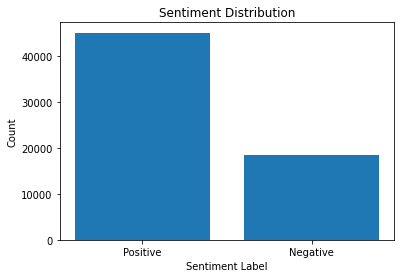

In [ ]:
# Count the number of each sentiment label
sentiment_counts = df.groupBy('Sentiment').count().collect()

# Extract the counts and labels into separate lists
labels = [row['Sentiment'] for row in sentiment_counts]
counts = [row['count'] for row in sentiment_counts]

# Create a bar graph
fig, ax = plt.subplots()
ax.bar(labels, counts)
ax.set_title('Sentiment Distribution')
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Count')
plt.show()

In [ ]:
# Group by month and sentiment
grouped = df.groupBy("Year", "Sentiment").count()

# Pivot the table to have months as columns and sentiments as rows
pivoted = grouped.groupBy("Sentiment").pivot("Year").sum("count")

# Display the plot using Databricks
display(pivoted, xlabel="Year", ylabel="count")

Sentiment,2011,2012,2013,2014,2015
Positive,1590,4098,13790,18345,7167
Negative,777,1791,5208,7905,2655


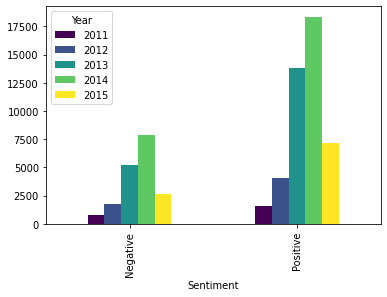

In [ ]:
pdf = df.toPandas()

# Group by month and sentiment
grouped = pdf.groupby(['Year', 'Sentiment']).size().reset_index(name='count')

# Pivot the table to have months as columns and sentiments as rows
pivoted = grouped.pivot(index='Sentiment', columns='Year', values='count')

# Create a bar plot
pivoted.plot(kind='bar', cmap='viridis')
plt.show()

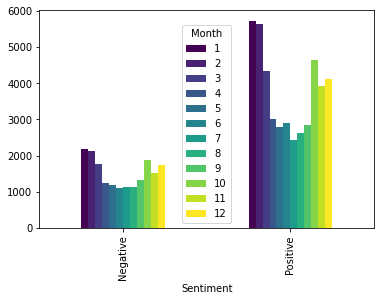

In [ ]:
# Group by month and sentiment
grouped = pdf.groupby(['Month', 'Sentiment']).size().reset_index(name='count')

# Pivot the table to have months as columns and sentiments as rows
pivoted = grouped.pivot(index='Sentiment', columns='Month', values='count')

# Create a bar plot
pivoted.plot(kind='bar', cmap='viridis')
plt.show()

In [ ]:
# Filter any rows for which the Publication column contains an invalid value
options = ['bbchealth', 'cbchealth', 'cnnhealth', 'everydayhealth', 'foxnewshealth', \
  'gdnhealthcare', 'goodhealth', 'KaiserHealthNews', 'latimeshealth', 'msnhealthnews'\
  , 'NBChealth', 'nprhealth', 'nytimeshealth', 'reuters_health', 'usnewshealth', \
  'wsjhealth',]

df = df.filter(df['Publication'].isin(options))

unique_values = [row.Publication for row in df.select('Publication').distinct().collect()]
print(unique_values)

['everydayhealth', 'KaiserHealthNews', 'nprhealth', 'usnewshealth', 'bbchealth', 'foxnewshealth', 'cnnhealth', 'latimeshealth', 'goodhealth', 'NBChealth', 'nytimeshealth', 'cbchealth', 'wsjhealth', 'gdnhealthcare', 'msnhealthnews', 'reuters_health']


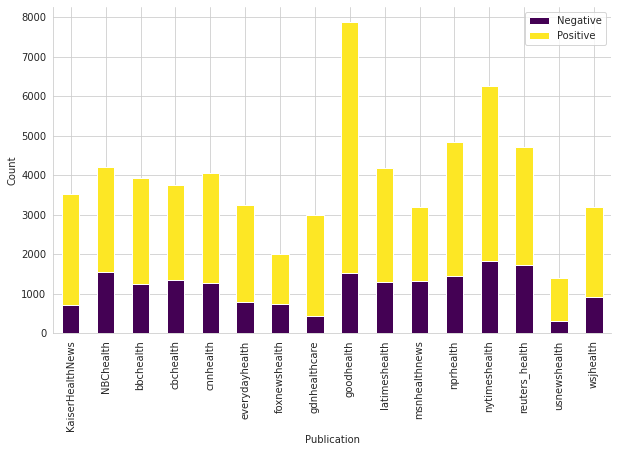

In [ ]:
# Group the data by 'Publication' and 'Sentiment' and count the number of rows in each group
grouped_df = df.groupBy('Publication', 'Sentiment').count()

# Sort the data by the order of the publications
grouped_df_ordered = grouped_df.orderBy(F.when(F.col('Publication').isin(options), F.col('Publication')).otherwise(F.lit('ZZZ')))

# Convert the Spark DataFrame to a Pandas DataFrame for plotting a graph
pandas_df = grouped_df_ordered.toPandas()

# Pivot the data to create a table with 'Publication' on the X-axis, 'Positive' and 'Negative' on the Y-axis, and the count of rows as the values
pivot_df = pandas_df.pivot(index='Publication', columns='Sentiment', values='count').fillna(0)

# Create a stacked bar chart using Seaborn
sns.set_style("whitegrid")
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0, cmap='viridis')
ax.set_xlabel("Publication")
ax.set_ylabel("Count")
ax.legend(["Negative", "Positive"], loc='upper right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine()

# Show the chart
plt.show()

In [ ]:
# Convert the Sentiment feature from string to numeric type using StringIndexer
labelIndexer = StringIndexer(inputCol="Sentiment", outputCol="label", handleInvalid="keep")
df = labelIndexer.fit(df).transform(df)
df = df.drop("Sentiment")

## Split Data into Training and Testing Sets

In [ ]:
# splits the data into 70% for the training set and 30% for the testing set, with a random seed of 134
train_data, test_data = df.randomSplit([0.7, 0.3], seed=134)

In [ ]:
df.show(10)

+-----------+----+-----+--------------------+-----+
|Publication|Year|Month|        bag_of_words|label|
+-----------+----+-----+--------------------+-----+
|  bbchealth|2015|    4|(86721,[31,41,87,...|  1.0|
|  bbchealth|2015|    4|(86721,[0,46,641,...|  1.0|
|  bbchealth|2015|    4|(86721,[0,41,72,7...|  0.0|
|  bbchealth|2015|    4|(86721,[0,120,257...|  0.0|
|  bbchealth|2015|    4|(86721,[0,55,63,3...|  0.0|
|  bbchealth|2015|    4|(86721,[5,63,86,2...|  0.0|
|  bbchealth|2015|    4|(86721,[0,1,12,42...|  0.0|
|  bbchealth|2015|    4|(86721,[0,6,46,81...|  0.0|
|  bbchealth|2015|    4|(86721,[0,6,81,15...|  1.0|
|  bbchealth|2015|    4|(86721,[0,8,63,11...|  0.0|
+-----------+----+-----+--------------------+-----+
only showing top 10 rows



In [ ]:
train_data.printSchema()

root
 |-- Publication: string (nullable = false)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- bag_of_words: vector (nullable = true)
 |-- label: double (nullable = false)



## Create Pipelines using Spark ML

In [ ]:
# Create a string indexer for publication feature and then drop the original string type feature
Publication_indexer = StringIndexer(inputCol="Publication", outputCol="Publication_index", handleInvalid="keep").fit(train_data)
train_data = Publication_indexer.transform(train_data).drop("Publication")

# One-hot encode the Publication feature
encoder = OneHotEncoder(inputCol="Publication_index", outputCol="Publication_vec", handleInvalid="keep")

feature_cols = train_data.columns
feature_cols.remove('label')

# Create vector assembler to combine input features into a single feature vector named 'features'
vectorAssembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")

In [ ]:
# Define Naive Bayes model
nb = NaiveBayes(modelType="multinomial", labelCol="label", featuresCol="features")

In [ ]:
# Define the Decision Tree model
dt = DecisionTreeClassifier(maxDepth=2,maxBins=17, labelCol='label', featuresCol='features')

In [ ]:
# Create parameter grid for Naive Bayes model
nb_paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .build()

In [ ]:
# Create parameter grid for Decision Tree model
dt_paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5]) \
    .addGrid(dt.maxBins, [32, 64]) \
    .build()

In [ ]:
# Define evaluator for evaluating models using f1 score metric
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

In [ ]:
# Define cross-validators for each of the Naive Bayes and Decision Tree methods

nb_cv = CrossValidator(estimator=nb, estimatorParamMaps=nb_paramGrid, evaluator=evaluator_f1)

dt_cv = CrossValidator(estimator=dt, estimatorParamMaps=dt_paramGrid, evaluator=evaluator_f1)

In [ ]:
# Chain indexers, encoder and model in Pipelines for Naive Bayes and Decision Tree
nb_pipeline = Pipeline(stages=[Publication_indexer, encoder, vectorAssembler, nb_cv])

dt_pipeline = Pipeline(stages=[Publication_indexer, encoder, vectorAssembler, dt_cv])

In [ ]:
# Fit Naive Bayes pipeline to the training data
nb_pipelineModel = nb_pipeline.fit(train_data)

In [ ]:
# Fit Decision Tree pipeline to the training data
dt_pipelineModel = dt_pipeline.fit(train_data)

## Evaluate the results

In [ ]:
# Obtain a set of predictions for Naive Bayes model
nb_predictions_f1 = nb_pipelineModel.transform(test_data)

In [ ]:
# Obtain a set of predictions for Decision Tree model
dt_predictions_f1 = dt_pipelineModel.transform(test_data)

In [ ]:
# Print the first 25 predictions for each model, comparing the tweet content's bag of words feature and prediction feature
nb_predictions_f1.select("bag_of_words", "prediction").show(25)

dt_predictions_f1.select("bag_of_words", "prediction").show(25)

+--------------------+----------+
|        bag_of_words|prediction|
+--------------------+----------+
|(86721,[1,53,266,...|       1.0|
|(86721,[0,1,12,18...|       0.0|
|(86721,[0,1,13,16...|       0.0|
|(86721,[0,1,39,80...|       0.0|
|(86721,[0,1,48,69...|       0.0|
|(86721,[0,1,67,27...|       0.0|
|(86721,[0,1,72,97...|       0.0|
|(86721,[0,1,109,1...|       1.0|
|(86721,[0,2,3,4,5...|       0.0|
|(86721,[0,2,4,41,...|       1.0|
|(86721,[0,2,5,112...|       1.0|
|(86721,[0,2,9,22,...|       0.0|
|(86721,[0,2,10,63...|       0.0|
|(86721,[0,2,27,25...|       0.0|
|(86721,[0,3,10,11...|       0.0|
|(86721,[0,3,10,12...|       0.0|
|(86721,[0,3,26,64...|       1.0|
|(86721,[0,3,225,3...|       1.0|
|(86721,[0,3,382,4...|       0.0|
|(86721,[0,4,31,85...|       1.0|
|(86721,[0,4,48,99...|       0.0|
|(86721,[0,4,110,1...|       0.0|
|(86721,[0,4,110,3...|       0.0|
|(86721,[0,6,9,12,...|       0.0|
|(86721,[0,6,10,17...|       1.0|
+--------------------+----------+
only showing t

In [ ]:
# Obtain f1 score for each model
f1_score_bayes = evaluator_f1.evaluate(nb_predictions_f1)

f1_score_decision_tree = evaluator_f1.evaluate(dt_predictions_f1)

In [ ]:
# display the f1 score for both the models
print("Naive Bayes F1 Score: " + str(f1_score_bayes))
print("Decision Tree F1 Score: " + str(f1_score_decision_tree))

Naive Bayes F1 Score: 0.8541994525048965
Decision Tree F1 Score: 0.743535344021001


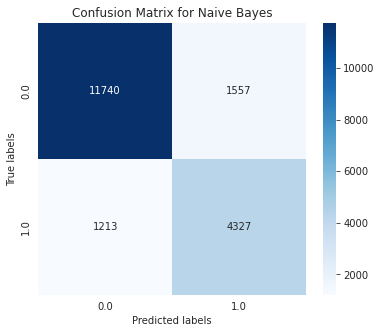

In [ ]:
# Create a confusion matrix of Naive Bayes model for plotting using matplotlib
nb_confusion_matrix = nb_predictions_f1.groupBy("label", "prediction").count().orderBy("label", "prediction").toPandas()
nb_confusion_matrix = nb_confusion_matrix.pivot(index="label", columns="prediction", values="count")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(nb_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Confusion Matrix for Naive Bayes")
plt.show()

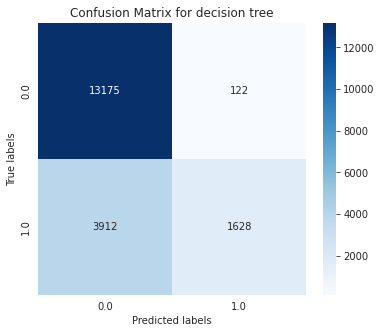

In [ ]:
# Create a confusion matrix of Decision Tree model for plotting using matplotlib
dt_confusion_matrix = dt_predictions_f1.groupBy("label", "prediction").count().orderBy("label", "prediction").toPandas()
dt_confusion_matrix = dt_confusion_matrix.pivot(index="label", columns="prediction", values="count")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(dt_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Confusion Matrix for decision tree")
plt.show()

In [ ]:
df.unpersist()

In [ ]:
spark.stop()